# **Phase 2 - Milestone 2**

**Ediashta Revindra Amirussalam**
<br>FTDS-020-RMT

## Objective

Emosi adalah keadaan psikologis kompleks yang melibatkan perasaan, pikiran, dan perubahan fisiologis. Emosi dapat mencakup perasaan positif, negatif, atau netral dan memainkan peran penting dalam interaksi sosial, pengambilan keputusan, dan kesejahteraan psikologis seseorang. Ekspresi wajah kadang-kadang dapat memberikan petunjuk tentang emosi atau reaksi seseorang, tetapi mereka bukanlah indikator yang dapat diandalkan untuk mengetahui apakah seseorang berbicara jujur atau tidak. Ide bahwa ekspresi wajah tertentu terkait dengan kebohongan didasarkan pada "teori mikroekspresi" yang dipopulerkan oleh psikolog Paul Ekman. Menurut teori ini, beberapa ekspresi wajah singkat dapat mengungkapkan emosi sebenarnya seseorang, meskipun mereka berusaha menyembunyikannya.

WalMart .Inc adalah sebuah perusahaan ritel asal amerika serikat yang bergerak pada bidang hypermarket serta grocery dengan skala multi-nasional. Sebagai salah satu yang terdepan dalam dunia ritel, WalMart ingin selalu menjaga tingkat kepuasan pelanggan mereka agar mereka tetap setia berbelanja pada WalMart. 

Oleh karena itu, untuk menjaga tingkat kepuasan pelanggan, WalMart berencana melakukan sebuah survey terkait kepuasan pelanggan setiap dua minggu sekali, sehingga WalMart membutuhkan sebuah cara agar dapat dengan cepat mengumpulkan hasil survey yang kemudian dapat digunakan sebagai analisis pelanggan. 



Sebagai Data Analyst Pada WalMart .Inc, kita diminta untuk melakukan sebuah pemodelan agar dapat mengetahui tingkat kepuasan pengguna dengan cepat. Salah satu metrics dari kepuasan pelanggan adalah melalui emosi mereka saat berbelanja, kita dapat mengetahui emosi pelanggan melalui ekspresi wajah yang mereka berikan. Oleh karena itu kita akan melakukan sebuah pemodelan yang akan melakukan prediksi dan klasifikasi pada ekspresi pengguna menggunakan Convolutional Neural Network (CNN), kemudian kita dapat memberikan insight terkait hasil pemodelan tersebut

## 00 - Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
import random

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [4]:
tf.__version__

'2.10.1'

In [5]:
#check gpu compatibility
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 01 - Data Loading

Dataset yang digunakan pada kali ini merupakan dataset FER2013 yang berisikan lebih dari 30.000 data yang dibagi kedalam 7 emosi dasar manusia antara lain:
* Angry
* Disgust
* Fear
* Happy
* Neutral
* Sad
* Suprised

Dataset dapat diakses melalui link berikut:
[FER2013 - Kaggle](https://www.kaggle.com/code/odins0n/emotion-detection)

### Google Colab

In [6]:
# from google.colab import drive
# drive.flush_and_unmount()

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
# !rm ~/.kaggle

In [9]:
# !mkdir ~/.kaggle

# !cp '/content/drive/MyDrive/kaggle/kaggle.json' ~/.kaggle

In [10]:
# !ls ~/.kaggle

In [11]:
# !kaggle datasets download -d ananthu017/emotion-detection-fer

In [12]:
# !unzip -q /content/emotion-detection-fer.zip -d images

In [13]:
# main_path = ('/content/images')
# os.listdir(main_path)

### Local

In [14]:
#set path to dataset

main_path = ('./datasets')
os.listdir(main_path)

['test', 'train']

### Extraction

In [15]:
#assign train and test set

train_dir = os.path.join(main_path, 'train')
test_dir = os.path.join(main_path, 'test')
os.listdir(train_dir)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

Terdapat 2 folder pada dataset yaitu train dan test, yang masing-masing berisikan 7 folder berdasarkan emosi

In [16]:
#define function to check folder in given directory

def check_dir(dir=None, labels=None):
  i=0
  for label in labels:
    num_data= len(os.listdir(os.path.join(dir, label)))
    print(f'Data', label, ' :', num_data)
    i+= num_data
  print('Total Data :', i)



In [17]:
print('train set: \n' + '='*50)
check_dir(train_dir,os.listdir(train_dir))
print('\ntest set: \n' + '='*50)
check_dir(test_dir,os.listdir(test_dir))

train set: 
Data angry  : 3995
Data disgusted  : 436
Data fearful  : 4097
Data happy  : 7215
Data neutral  : 4965
Data sad  : 4830
Data surprised  : 3171
Total Data : 28709

test set: 
Data angry  : 958
Data disgusted  : 111
Data fearful  : 1024
Data happy  : 1774
Data neutral  : 1233
Data sad  : 1247
Data surprised  : 831
Total Data : 7178


Total data pada dataset ini yaitu 28709 pada train-set dan 7178 pada test-set

## 02 - EDA & Preprocessing

### Display Sample Image

(48, 48)


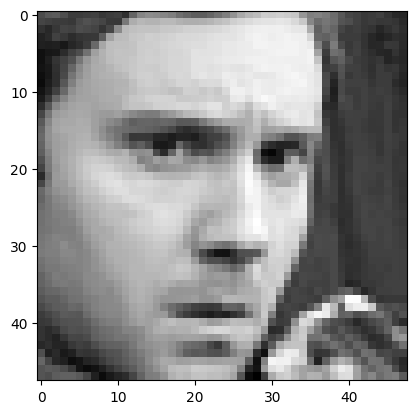

In [18]:
#display sample image

img = plt.imread(f'{train_dir}/angry/im0.png')
print(img.shape)
plt.imshow(img, cmap="gray")

Pada dataset ini, dimensi gambar adalah **48x48** pixel dengan color profile **grayscale**

#### Image Distribution

In [19]:
#assign parameter used

class_labels  = [class_name.capitalize() for class_name in os.listdir(train_dir)]
img_height = 48
img_width = 48
batch_size = 64

In [20]:
#create variable to count each image

img_count = pd.DataFrame(columns=['label', 'count'])

for i in os.listdir(train_dir):
    value = len([fn for fn in os.listdir(f'{train_dir}/{i}/') if fn.endswith('.png')])
    img_count.loc[len(img_count.index)] = [i, value]

img_count.sort_values(by="count", ascending=False, inplace=True)

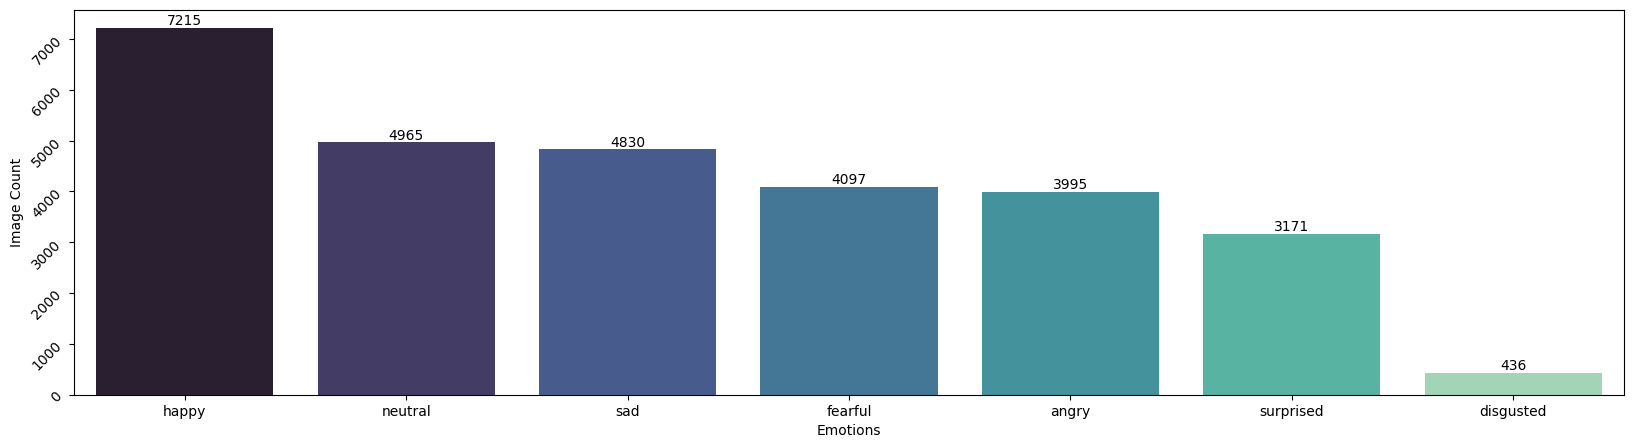

In [21]:
#plot image distribution

plt.figure(figsize=(20,5))
fig = sns.barplot(x="label",
                  y="count",
                  data=img_count,
                  palette="mako")
fig.set(xlabel="Emotions", ylabel="Image Count")

for i in fig.containers:
    fig.bar_label(i,)

plt.yticks(rotation=45)
plt.show()

Pada dataset ini, jumlah data antar kelas dapat dikatakan tidak berimbang, terlihat jauh lebih banyak data pada emosi bahagia dan pada emosi jijik jumlah data sangat sedikit, sedangkan untuk emosi lainnya cukup merata. Hal ini kemungkinan dapat memengaruhi kemampuan mesin dalam mempelajari data dengan jumlah sedikit dan cendereung memprediksi emosi kedalam kategori bahagia

### Individual Emotion Analysis

Kita dapat menganalisa tiap jenis emosi pada dataset untuk mengetahui karakteristik dari masing-masing emosi, kita dapat mengidentifikasi karakteristik melalui fitur wajah seperti alis, mata, hidung, dan mulut

In [22]:
#define function to show image based on give class

def visualize_img(title, train_dir):
    random.seed(5)
    images = random.sample([fn for fn in os.listdir(f'{train_dir}/{title}') if fn.endswith('.png')],7)
    fig, axes = plt.subplots(1,7, figsize=(21,5))

    #loop each image
    for i, x in enumerate(images):
        img = plt.imread(f'{train_dir}/{title}/{x}')
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(title.capitalize())
        axes[i].axis('off')

    fig.tight_layout()

#### Angry

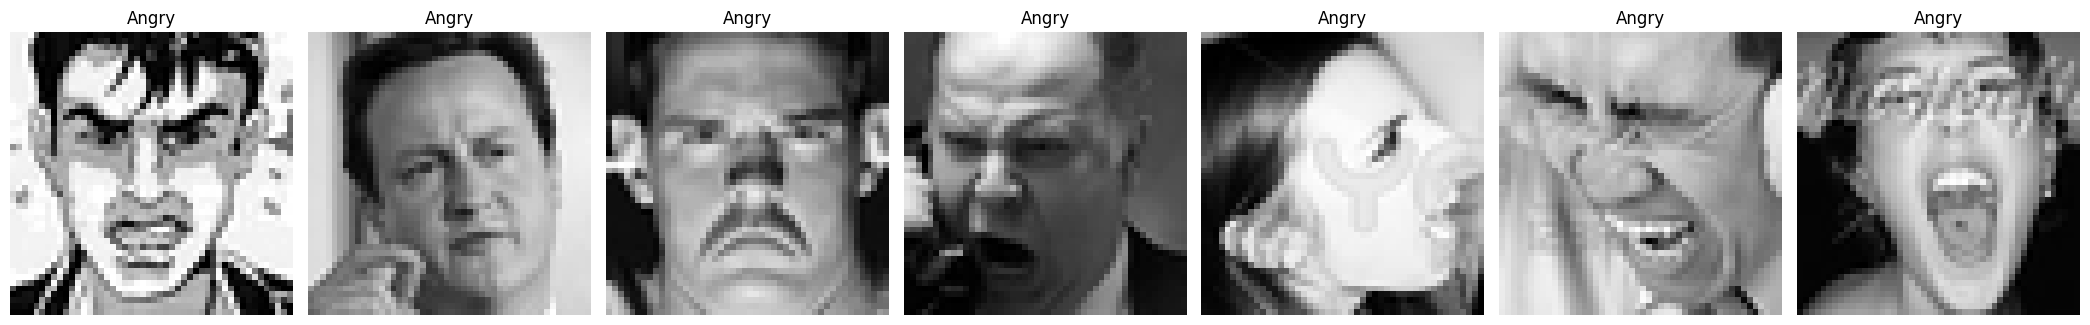

In [23]:
visualize_img('angry', train_dir)

Emosi ini biasanya ditandai dengan perasaan amarah, frustrasi, dan ketidakpuasan terhadap sesuatu yang dianggap mengancam atau menyakitkan. 

Ciri Fisik:
* Bagian luar alis terangkat
* Mata biasanya menyipit dan tajam
* Bagia mulut menegang

#### Disgusted

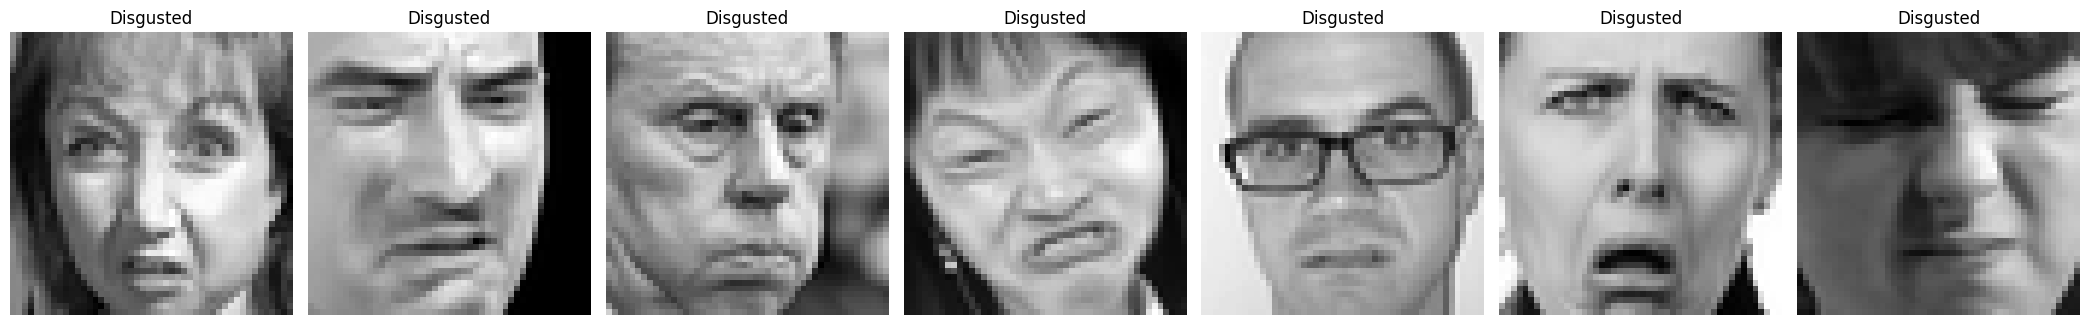

In [24]:
visualize_img('disgusted', train_dir)

Emosi ini berkaitan dengan perasaan takut atau merasa terganggu oleh sesuatu yang tidak disukai atau dianggap menjijikkan.

Ciri Fisik:
* Bagian alis terangkat
* Kelopak mata bagian bahwa terangkat
* Hidung mengkerut
* Biasanya bagian mulut terlihat sedikit menegang dan sedikit terangkat

#### Fearful

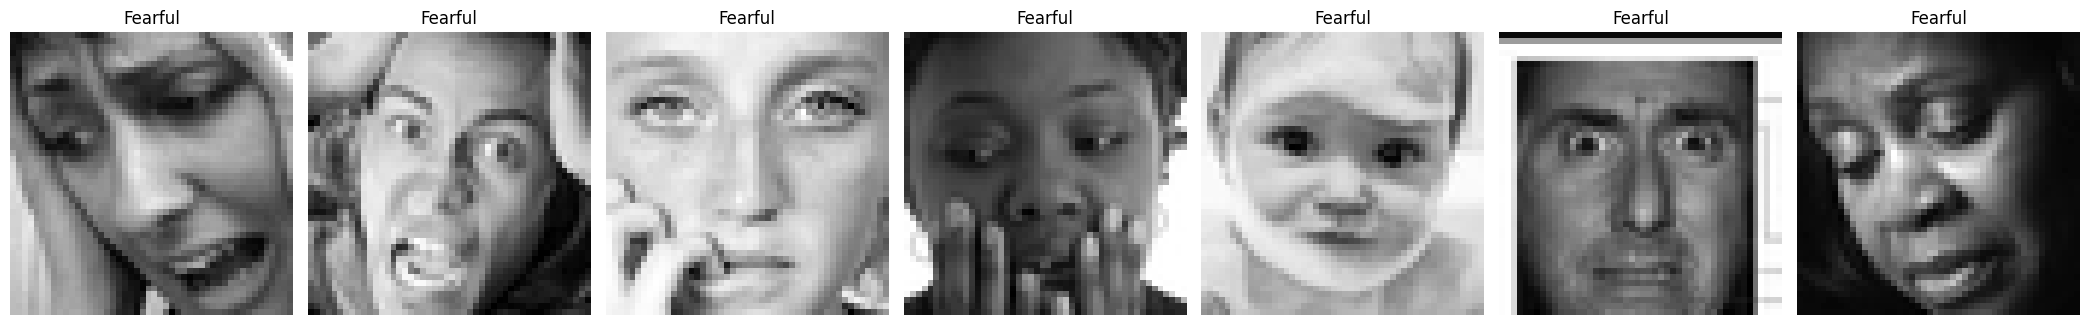

In [25]:
visualize_img('fearful', train_dir)

 Emosi ini melibatkan perasaan ketakutan atau cemas karena ada ancaman atau bahaya.
 
 Ciri Fisik:
 * Mata Melebar
 * Alis bagian luar sedikit turun
 * Mulut biasanya sedikit menurun
 * Pada emosi ini biasanya tangan digunakan untuk menutup bagian wajah

#### Happy

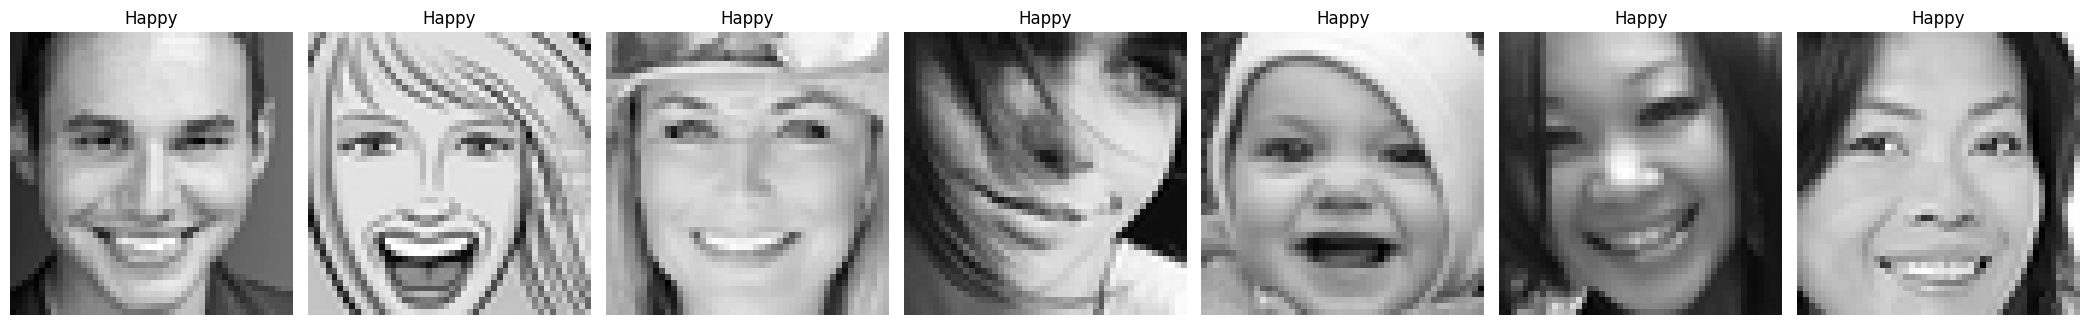

In [26]:
visualize_img('happy', train_dir)

Emosi ini biasanya ditandai dengan perasaan senang, gembira, dan puas. Ekspresi wajah yang bahagia mencakup senyuman, mata yang berbinar, serta cenderung bersifat terbuka dan ramah.

Ciri Fisik:
* Mata telihat berbinar
* Mulut tersenyum

#### Neutral

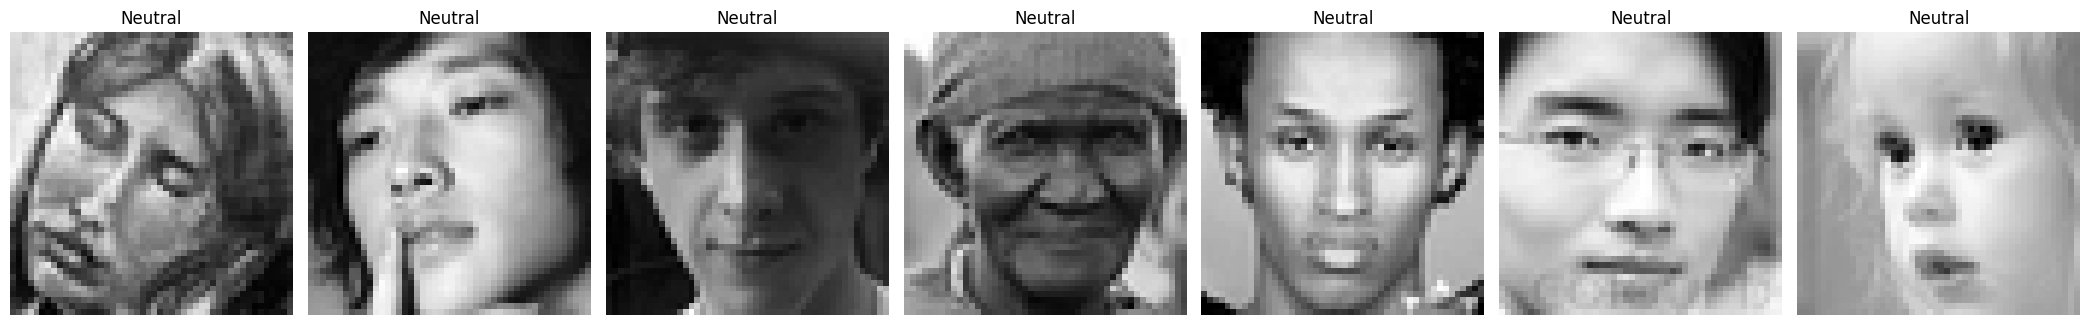

In [27]:
visualize_img('neutral', train_dir)

Emosi netral menunjukkan ketiadaan emosi yang kentara atau ekspresi wajah yang tidak menunjukkan perasaan intens.

Ciri Fisik pada ekspresi ini adalah tiap fitur wajah terlihat tidak menonjol

#### Sad

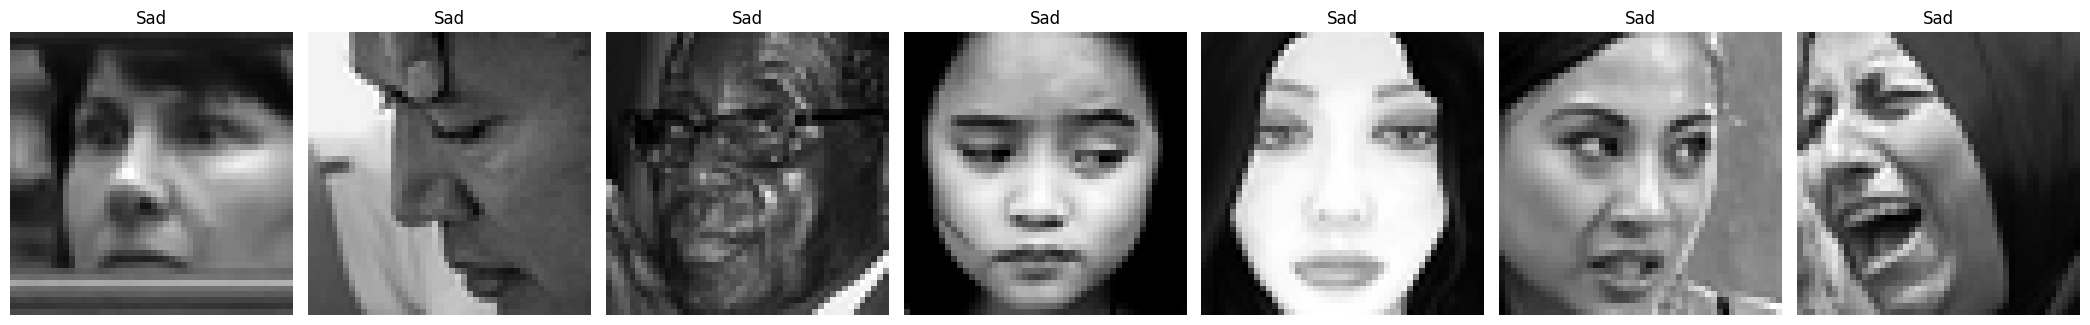

In [28]:
visualize_img('sad', train_dir)

Emosi ini melibatkan perasaan kesedihan, kekecewaan, dan kehilangan

Ciri Fisik:
* Alis biasanya terlihat mengkerut
* Mata menjadi lesu
* Bagian sudut mulut sedikit menurun

#### Surprised

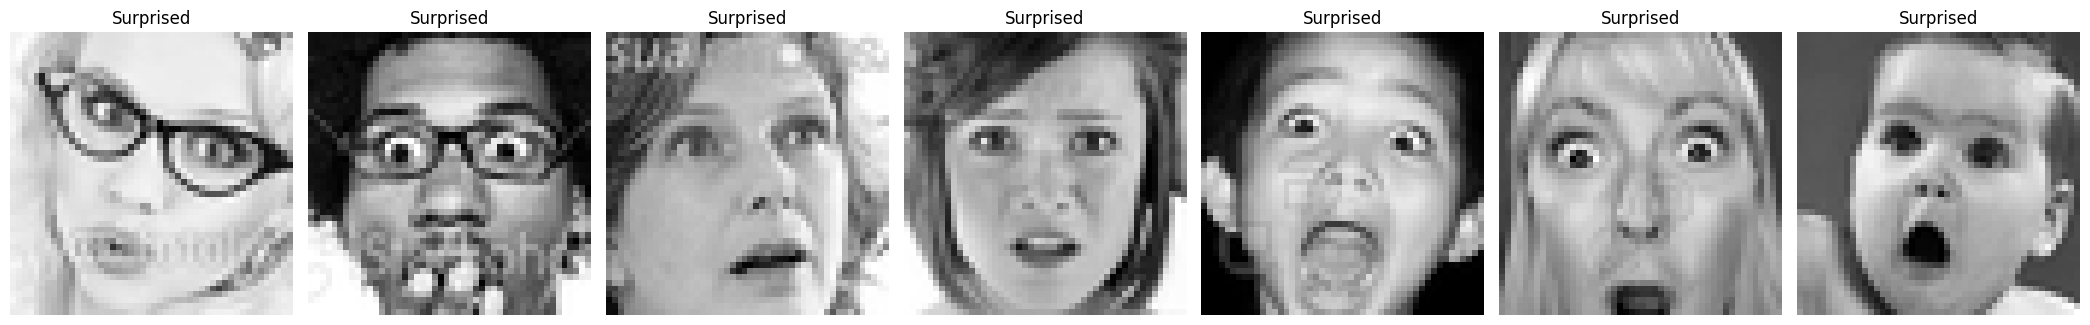

In [29]:
visualize_img('surprised', train_dir)

Emosi ini muncul ketika seseorang mendapat peristiwa atau informasi yang tak terduga.

Ciri Fisik:
* Alis naik secara keseluruhan
* Mata melebar
* Biasanya mulut terbuka

### Image Vector Mean

Kemudian kita dapat melihat karakteristik dari tiap kelas pada dataset dengan menggunakan mean dari tiap-tiap gambar

In [30]:
#define function to convert image to matrix

def img2np(path, list_of_filename, size = (48, 48)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size,
                                       color_mode = 'grayscale')
        
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError:
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

In [31]:
def find_mean_img(full_mat, title, axes, loc, size = (48, 48)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)

    # mean_img = sharpened

    axes[loc].imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    axes[loc].set_title(f'Average {title}')
    return mean_img

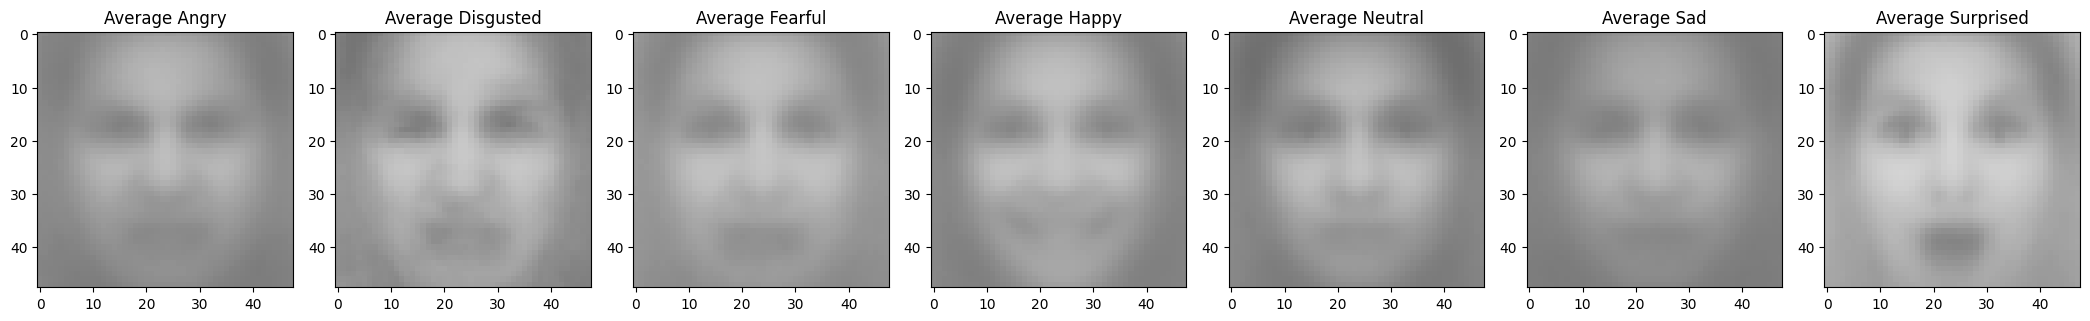

In [32]:
#show mean of image for each class

fig, axes= plt.subplots(1,7, figsize=(21,3))
count = 0

#loop for each class
for i in os.listdir(train_dir):
    images = [fn for fn in os.listdir(f'{train_dir}/{i}') if fn.endswith('.png')]
    vector = img2np(f'{train_dir}/{i}/',images)
    find_mean_img(vector, i.capitalize(),axes, count)

    count+=1

plt.tight_layout()
plt.show()

Dari perhitungan mean ini didapatkan informasi sebagai berikut:
* Ekspresi yang paling menonjol adalah Happy dan Surprised, dapat mudah diidentifikasi dari karakteristik mulut
* Untuk ekspresi Sad, Fearful dan Netral, agak sedikit sulit untuk dibedakan
* Sedangkan ekspresi Angry dan Disgusted terlihat mirip dari karakteristik alis dan mulutnya

### Preprocessing and Augmentation

Selanjutnya, kita bisa melakukan preprocessing pada data dan melakukan augmentasi pada data gambar, dibagi menjadi dua variable yaitu train_datagen dan test_datagen. Kemudian kita akan mengambil gambar yang berbeda dari tiap directory dan menerapkan augmentasi sesuai yang kita tentukan dan memasukkannya kedalam tensor

Augmentasi pada data gambar perlu dilakukan untuk regularisasi, meningkatkan generalisasi model terhadap data dan mengurangi risiko overfitting

In [33]:
#create preprocessor and augmentation for batch image

preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   rotation_range=15,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_fun)

train_ds = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_height ,img_width),
                                                    batch_size = batch_size,
                                                    shuffle  = True ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                   )

test_ds = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (img_height ,img_width),
                                                    batch_size = batch_size,
                                                    shuffle  = False ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## 03 - Base Model

Untuk pemodelan, kita akan menggunakan Sequential API dan 2D Convolution layer

### Model Definition

In [34]:
# clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [35]:
# define the input shape and number of classes for your dataset

input_shape = (img_height, img_width, 3)
num_classes = 7

In [36]:
#define sequential model
model = Sequential()

#convolution layer
model.add(
       Conv2D(
       filters=64,
       kernel_size=(5,5),
       input_shape=input_shape,
       activation='elu',
       padding='same',
       kernel_initializer='he_normal',
       name='conv2d_1'
       )
)
model.add(BatchNormalization(name='batchnorm_1'))
model.add(
       Conv2D(
       filters=64,
       kernel_size=(5,5),
       activation='elu',
       padding='same',
       kernel_initializer='he_normal',
       name='conv2d_2'
       )
)
model.add(BatchNormalization(name='batchnorm_2'))

model.add(MaxPool2D(pool_size=(2,2), name='maxpool2d_1'))
model.add(Dropout(0.4, name='dropout_1'))

model.add(
       Conv2D(
       filters=128,
       kernel_size=(3,3),
       activation='elu',
       padding='same',
       kernel_initializer='he_normal',
       name='conv2d_3'
       )
)
model.add(BatchNormalization(name='batchnorm_3'))
model.add(
       Conv2D(
       filters=128,
       kernel_size=(3,3),
       activation='elu',
       padding='same',
       kernel_initializer='he_normal',
       name='conv2d_4'
       )
)
model.add(BatchNormalization(name='batchnorm_4'))

model.add(MaxPool2D(pool_size=(2,2), name='maxpool2d_2'))
model.add(Dropout(0.4, name='dropout_2'))

model.add(
       Conv2D(
       filters=256,
       kernel_size=(3,3),
       activation='elu',
       padding='same',
       kernel_initializer='he_normal',
       name='conv2d_5'
       )
)
model.add(BatchNormalization(name='batchnorm_5'))
model.add(
       Conv2D(
       filters=256,
       kernel_size=(3,3),
       activation='elu',
       padding='same',
       kernel_initializer='he_normal',
       name='conv2d_6'
       )
)
model.add(BatchNormalization(name='batchnorm_6'))

model.add(MaxPool2D(pool_size=(2,2), name='maxpool2d_3'))
model.add(Dropout(0.5, name='dropout_3'))

#dense layer
model.add(Flatten(name='flatten'))
       
model.add(
       Dense(
       128,
       activation='elu',
       kernel_initializer='he_normal',
       name='dense_1'
       )
)
model.add(BatchNormalization(name='batchnorm_7'))

model.add(Dropout(0.6, name='dropout_4'))

model.add(
       Dense(
       num_classes,
       activation='softmax',
       name='out_layer'
       )
)

**Model Explanation**
* Kita menerapkan convolutional pada gambar menggunakan Conv2D untuk menghasilkan sebuah identifikasi fitur pada kelas yang telah kita assign
* Kemudian dilakukan BatchNormalization untuk normalisasi pada model agar menghasilkan model yang stabil dan dapat converge
* MaxPooling2D digunakan untuk mereduksi dimensi dan jumlah parameter pada model
* Kemudian kita lakukan Dropout yaitu melakukan dropping pada data input neuron ke layer berikutnya sesuai dengan jumlah yang kita tentukan
* Setelah semua proses convolutional dilakukan, kita dapat melakukan Flatten untuk konversi array 2 Dimensi menjadi sebuah array 1 dimensi
* Dan terakhir kita gunakan Dense layer sebagai hidden layer dan output layer

Beberapa parameter yang digunakan adalah sebagai berikut:
* `elu` : Activation ELU dipilih untuk menghindari vanishing gradient yang rentan terjadi apabila menggunakan ReLU
* `he_normal` : Kernel Initializer ini dipilih karena memang cocok untuk ELU dan dapat membantu mempercepat converge pada model
* `softmax` : Activation Softmax adalah activation yang biasa digunakan pada output layer untuk multiclass, Softmax akan memberikan hasil prediksi berupa probabilitas dari setiap kelasnya

Untuk compiling model, kita gunakan beberapa parameter sebagai berikut:
* `loss = categorical_crossentropy` : karena kita akan melakukan prediksi multiclass, kita menggunakan categorical_crossentropy karena tiap data tidak selalu ekslusif dikategorikan sebagai kelas tertentu, melainkan dapat merupakan gabungan dari beberapa kelas dengan bobot yang berbeda
* `optimizer = Adam` : Adam adalah salah satu jenins optimizer yang paling efisien
* `Accuracy` : Untuk klasifikasi, digunakan akurasi sebagai metrics untuk evaluasi performa dari model selama training

In [37]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        4864      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0

Dari pendefinisian model tersebut dihasilkan sebuah model dengan jumlah neuron sebanyak *2.398.791*

### Model Training

Kita dapat melanjutkan fitting model terhadap data train kita dengan validation menggunakan data test

In [38]:
history = model.fit(x = train_ds,
                    epochs = 50,
                    validation_data = test_ds)

Epoch 1/50
449/449 [==============================] - 57s 116ms/step - loss: 2.2100 - accuracy: 0.2304 - val_loss: 1.8281 - val_accuracy: 0.2626
Epoch 2/50
449/449 [==============================] - 26s 57ms/step - loss: 1.7022 - accuracy: 0.3344 - val_loss: 1.5025 - val_accuracy: 0.4202
Epoch 3/50
449/449 [==============================] - 26s 58ms/step - loss: 1.5193 - accuracy: 0.4122 - val_loss: 1.4016 - val_accuracy: 0.4705
Epoch 4/50
449/449 [==============================] - 26s 59ms/step - loss: 1.4043 - accuracy: 0.4599 - val_loss: 1.3691 - val_accuracy: 0.4870
Epoch 5/50
449/449 [==============================] - 26s 57ms/step - loss: 1.3290 - accuracy: 0.4935 - val_loss: 1.3750 - val_accuracy: 0.4744
Epoch 6/50
449/449 [==============================] - 26s 59ms/step - loss: 1.2781 - accuracy: 0.5134 - val_loss: 1.2092 - val_accuracy: 0.5435
Epoch 7/50
449/449 [==============================] - 26s 58ms/step - loss: 1.2347 - accuracy: 0.5336 - val_loss: 1.1651 - val_accuracy

In [39]:
history_df = pd.DataFrame(history.history)

history_df.tail()

,loss,accuracy,val_loss,val_accuracy
45,0.861369,0.681250,0.946733,0.656172
46,0.854996,0.685081,0.940836,0.662162
47,0.847815,0.688112,0.951860,0.650042
48,0.850097,0.687798,0.945464,0.659237
49,0.840133,0.692117,0.905235,0.675118


Dari 50 epoch yang dijalankan didapatkan nilai maksimal accuracy yang didapatkan adalah 69% dengan validation accuracy sebesar 67%, kita dapat melihat performa model pada tiap epoch pada plot dibawah

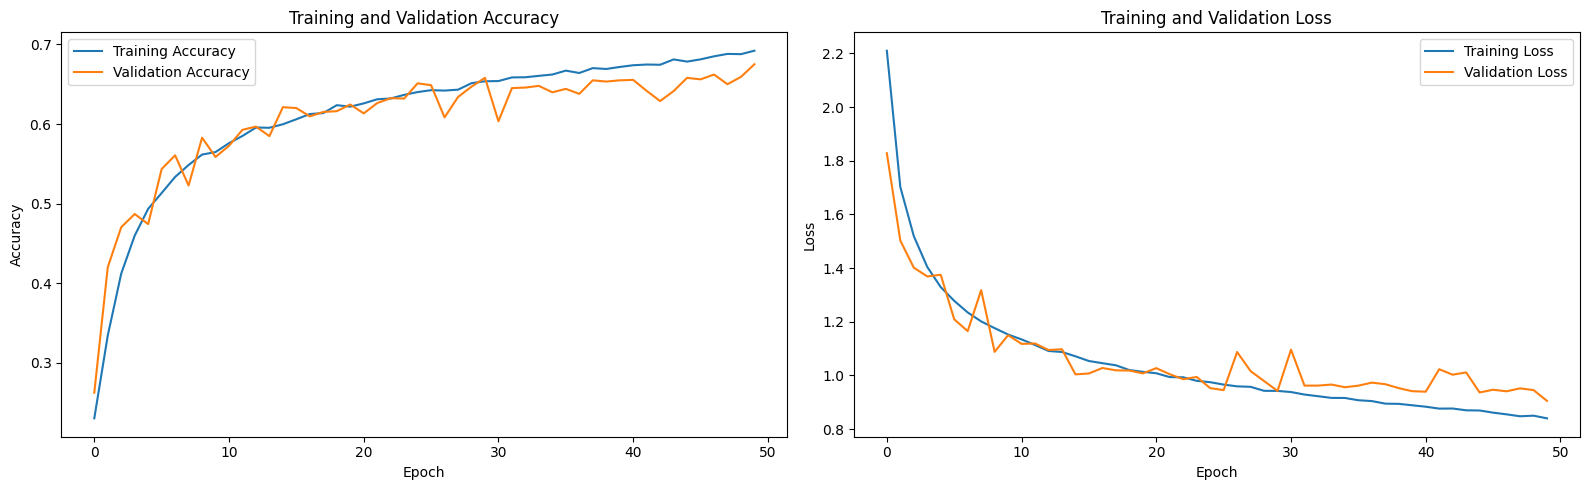

In [40]:
plt.figure(figsize=(16, 5))

# First subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history_df["accuracy"], label="Training Accuracy")
plt.plot(history_df["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Second subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history_df["loss"], label="Training Loss")
plt.plot(history_df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()

* Pada accuracy, terlihat bahwa model sedikit tidak stabil dalam melakukan validation, dapat diketahui dari grafik validation accuracy dan validation loss yang naik turun.
* Model terlihat mulai converge pada epoch ke 20-an
* Grafik tersebut juga terlihat belum menjadi plateau atau stagnan, yang berarti sebenarnya model masih dapat melakukan learning lebih jauh dengan ditingkatkannya **epoch**

In [41]:
#save model

model.trainable = False
# model.save("/content/drive/MyDrive/FTDS/Emotion Classification/model_default.h5") #google colab
model.save('./model/model_default.h5') #local

### Model Evaluation

Setelah itu kita dapat lakukan evaluasi terhadap model dan performanya dalam melakukan prediksi pada tiap kelasnya

In [42]:
#predict and evaluate model
model.evaluate(test_ds)
preds = model.predict(test_ds)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_ds.labels)

113/113 [==============================] - 3s 22ms/step


In [43]:
#create confusion matrix array
cm_array = confusion_matrix(y_true=y_test, y_pred=y_preds)

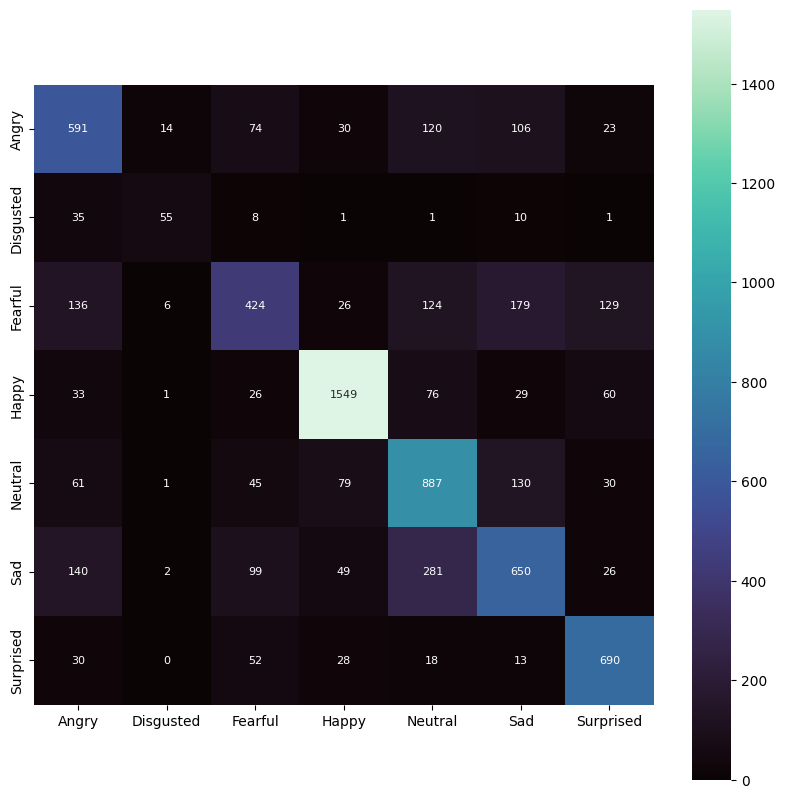

In [44]:
#display confusion matrix
plt.figure(figsize=(10,10))
ax = sns.heatmap(cm_array, cmap="mako",
                 annot=True, square=True,
                 annot_kws={"size": 8}, fmt='g',
                 xticklabels=class_labels, yticklabels=class_labels)


Dari confusion matrix tersebut, didapatkan insight sebagai berikut:
* model dapat identifikasi hampir semua kelas dengan jelas kecuali pada kelas disgusted
* Performa pada prediksi kelas Happy sangat bagus dengan nilai prediksi meleset hanya ±10%
* Pada kelas Netural dan Sad terdapat cukup banyak prediksi yang meleset, Sad diprediksi sebagai Neutral dan sebaliknya
* Hal tersebut mungkin berpengaruh dari jumlah data yang imbalance, serta ukuran gambar yang cukup kecil sehingga identifikasi fitur tidak maksimal

In [45]:
print(classification_report(y_true=y_test, y_pred=y_preds))

              precision    recall  f1-score   support

           0       0.58      0.62      0.60       958
           1       0.70      0.50      0.58       111
           2       0.58      0.41      0.48      1024
           3       0.88      0.87      0.88      1774
           4       0.59      0.72      0.65      1233
           5       0.58      0.52      0.55      1247
           6       0.72      0.83      0.77       831

    accuracy                           0.68      7178
   macro avg       0.66      0.64      0.64      7178
weighted avg       0.67      0.68      0.67      7178



Didapatkan rata-rata akurasi sebesar 68% dan performa model paling bagus pada prediksi kelas Happy

## 04 - Fine Tuned Model

Kemudian kita dapat melakukan fine tuning pada model dengan menambahkan beberapa layer maupun parameter

### Model Definition

In [46]:
# clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [49]:
def build_model():
        model = Sequential()
        
        model.add(
        Conv2D(
        filters=64,
        kernel_size=(5,5),
        input_shape=input_shape,
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
        )
        )
        model.add(BatchNormalization(name='batchnorm_1'))
        model.add(
        Conv2D(
        filters=64,
        kernel_size=(5,5),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
        )
        )
        model.add(BatchNormalization(name='batchnorm_2'))

        model.add(MaxPool2D(pool_size=(2,2), name='maxpool2d_1'))
        model.add(Dropout(0.4, name='dropout_1'))

        model.add(
        Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
        )
        )
        model.add(BatchNormalization(name='batchnorm_3'))
        model.add(
        Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
        )
        )
        model.add(BatchNormalization(name='batchnorm_4'))

        model.add(MaxPool2D(pool_size=(2,2), name='maxpool2d_2'))
        model.add(Dropout(0.4, name='dropout_2'))

        model.add(
        Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
        )
        )
        model.add(BatchNormalization(name='batchnorm_5'))
        model.add(
        Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
        )
        )
        model.add(BatchNormalization(name='batchnorm_6'))

        model.add(MaxPool2D(pool_size=(2,2), name='maxpool2d_3'))
        model.add(Dropout(0.5, name='dropout_3'))

        model.add(Flatten(name='flatten'))
        
        model.add(
        Dense(
        512,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense_1'
        )
        )
        model.add(BatchNormalization(name='batchnorm_7'))

        model.add(Dropout(0.6, name='dropout_4'))
        
        model.add(
        Dense(
        256,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense_2'
        )
        )
        model.add(BatchNormalization(name='batchnorm_8'))

        model.add(Dropout(0.6, name='dropout_5'))

        model.add(
        Dense(
        num_classes,
        activation='softmax',
        name='out_layer'
        )
        )
        
        model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy'])
        
        return model

Pada model ini, kita menambahkan sebuah layer baru dengan jumlah neuron 512 dan 256
* Kita menambahkan layer agar model memiliki depth yang lebih dan memastikan model dapat mengidentifikasi fitur
* Penambahan jumlah neuron agar model dapat menerima informasi lebih banyak dari layer sebelumnya

Perlu diperhatikan bahwa menggunakan layer yang terlalu banyak dapat menyebabkan gradient vanishing yang berakibat pada overfitting

In [50]:
model_ft = build_model() 

model_ft.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        4864      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)       

Sehingga dihasilkan jumlah neuron sebanyak 6.072.903, jauh lebih banyak dibandingkan model sebelumnya

### Model Training

Pada fine tuning ini, kita akan menerapkan callbacks, antara lain:
* Model Checkpoint : digunakan untuk melakukan saving checkpoint pada model dengan nilai terbaik
* Early Stopping : apabila model tidak menemukan hasil yang lebih baik dalam epoch yang ditentukan, maka model akan distop dan diambil hasil terbaik sebelumnya
* Reduce LR : ketika model sudah mencapai plateau sebanyak patience yang ditentukan, maka model akan melakukan reduksi terhadap learning rate agar model lebih converge

In [51]:
modelCheckpointCallback = ModelCheckpoint(
    # filepath='/content/drive/MyDrive/FTDS/Emotion Classification', #google colab
    filepath= './deployment/model/',
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True,
)

earlyStoppingCallback = EarlyStopping(monitor='val_accuracy',
                                      patience=10,
                                      verbose= 1 ,
                                      restore_best_weights=True
                                      )

reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", 
                              factor=0.2, 
                              patience=5, 
                              min_lr=0)

Untuk fitting kali ini, kita menambahkan jumlah epoch menjadi 100

In [52]:
history_ft = model_ft.fit(x = train_ds,
                    epochs = 100 ,
                    validation_data = test_ds , 
                    callbacks= [earlyStoppingCallback,
                                modelCheckpointCallback,
                                reduce_lr])

Epoch 1/100


449/449 [==============================] - 29s 63ms/step - loss: 2.3020 - accuracy: 0.2226 - val_loss: 1.8116 - val_accuracy: 0.2609 - lr: 0.0010
Epoch 2/100
449/449 [==============================] - 26s 59ms/step - loss: 1.7065 - accuracy: 0.3313 - val_loss: 1.5147 - val_accuracy: 0.4100 - lr: 0.0010
Epoch 3/100
449/449 [==============================] - 26s 58ms/step - loss: 1.5269 - accuracy: 0.4061 - val_loss: 1.4743 - val_accuracy: 0.4386 - lr: 0.0010
Epoch 4/100
449/449 [==============================] - 27s 59ms/step - loss: 1.4220 - accuracy: 0.4513 - val_loss: 1.4359 - val_accuracy: 0.4653 - lr: 0.0010
Epoch 5/100
449/449 [==============================] - 27s 59ms/step - loss: 1.3479 - accuracy: 0.4851 - val_loss: 1.2651 - val_accuracy: 0.5201 - lr: 0.0010
Epoch 6/100
449/449 [==============================] - 26s 59ms/step - loss: 1.3019 - accuracy: 0.5011 - val_loss: 1.2571 - val_accuracy: 0.5258 - lr: 0.0010
Epoch 7/100
449/449 [==============================] - 27s 60ms/

In [80]:
import winsound
winsound.Beep(440, 1000)

In [81]:
history_ft_df = pd.DataFrame(history_ft.history)

history_ft_df.tail()

,loss,accuracy,val_loss,val_accuracy,lr
76,0.767906,0.720192,0.889211,0.679159,0.000008
77,0.764152,0.720088,0.887046,0.678741,0.000008
78,0.763093,0.720018,0.887191,0.679994,0.000008
79,0.762793,0.717650,0.888021,0.679716,0.000008
80,0.761492,0.718381,0.888827,0.681109,0.000008


Didapatkan peningkatan pada metrics dari model, Accuracy meningkat dari sebelumnya 0.69 menjadi 0.72 dan Validation Accuracy meningkat dari sebelumnya 0.65 menjadi 0.68

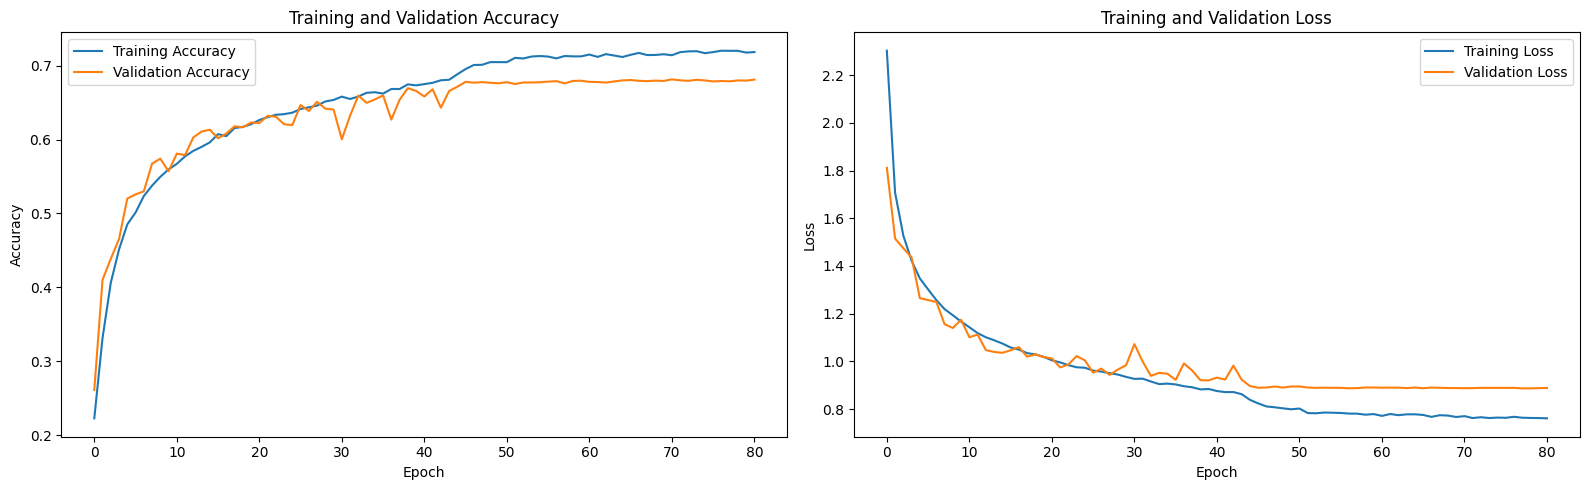

In [83]:
plt.figure(figsize=(16, 5))

# First subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history_ft_df["accuracy"], label="Training Accuracy")
plt.plot(history_ft_df["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Second subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history_ft_df["loss"], label="Training Loss")
plt.plot(history_ft_df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()

* Pada model ini terlihat bahwa model converge lebih cepat kurang dari 20 epoch
* Pada epoch ke 40-50 model mulai stagnan sehingga dilakukan reduksi learning rate
* Tetapi dapat dilihat bahwa model sedikit kurang stabil dalam melakukan validasi sebelum learning rate direduksi
* Dari hal tersebut, dapat kita katakan bahwa model ini masih underfit

In [84]:
model_ft.trainable = False
# model_ft.save("/content/drive/MyDrive/FTDS/Emotion Classification/model_fine_tune.h5") #google colab
model_ft.save('./model/model_fine_tune.h5') #local

### Model Evaluation

Kemudian ktia dapat evalueasi prediksi model terhadap tiap kelas

In [85]:
#predict and evaluate model
model_ft.evaluate(test_ds)
preds_ft = model_ft.predict(test_ds)
y_preds_ft = np.argmax(preds_ft , axis = 1 )
y_test_ft = np.array(test_ds.labels)

113/113 [==============================] - 3s 22ms/step


In [86]:
#create confusion matrix array
cm_array_ft = confusion_matrix(y_true=y_test_ft, y_pred=y_preds_ft)

Text(95.72222222222221, 0.5, 'True')

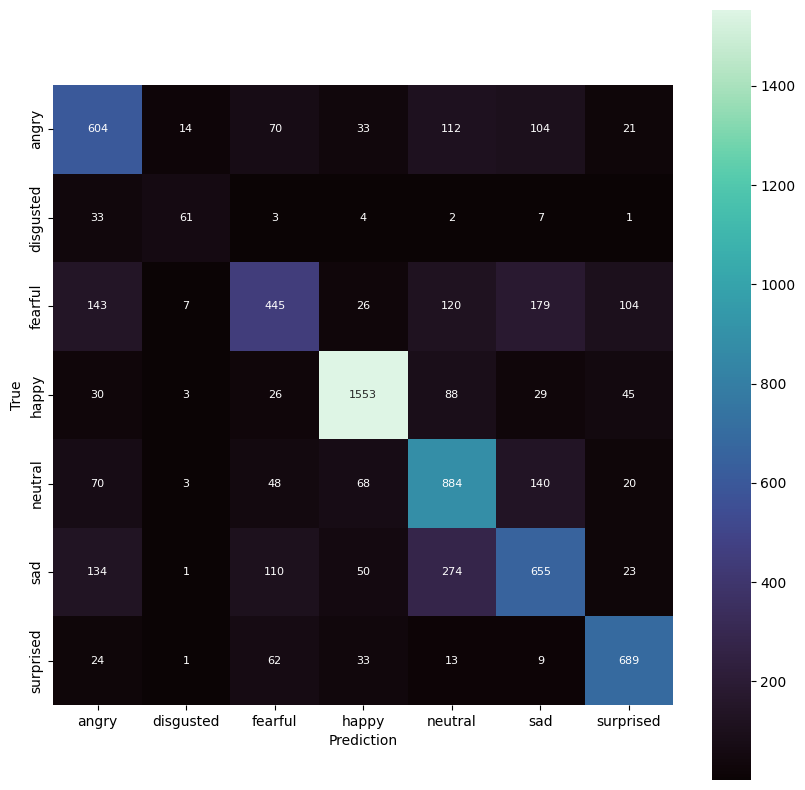

In [87]:
#display confusion matrix
plt.figure(figsize=(10,10))
ax = sns.heatmap(cm_array_ft, cmap="mako",
                 annot=True, square=True,
                 annot_kws={"size": 8}, fmt='g',
                 xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Prediction")
plt.ylabel("True")


Pada model ini, terdapat sedikit peningkatan terhadap hasil prediksi

In [88]:
print(classification_report(y_true=y_test_ft, y_pred=y_preds_ft))

              precision    recall  f1-score   support

           0       0.58      0.63      0.61       958
           1       0.68      0.55      0.61       111
           2       0.58      0.43      0.50      1024
           3       0.88      0.88      0.88      1774
           4       0.59      0.72      0.65      1233
           5       0.58      0.53      0.55      1247
           6       0.76      0.83      0.79       831

    accuracy                           0.68      7178
   macro avg       0.67      0.65      0.65      7178
weighted avg       0.68      0.68      0.68      7178



Dari hasil prediksi pemodelan tersebut didapatkan insight sebagai berikut

**Angry**
* Precision 58% yang berarti sebanyak 58% dari data angry yang diprediksi adalah benar
* Recall 63% yang berarti model dapat mengidentifikasi 63% data angry secara benar
  
**Disgusted**
* Precision 68% yang berarti sebanyak 68% dari data disgusted yang diprediksi adalah benar
* Recall 55% yang berarti model dapat mengidentifikasi 55% data disgusted secara benar

**Fearful**
* Precision 58% yang berarti sebanyak 58% dari data fearful yang diprediksi adalah benar
* Recall 43% yang berarti model dapat mengidentifikasi 43% data fearful secara benar

**Happy**
* Precision 88% yang berarti sebanyak 88% dari data happy yang diprediksi adalah benar
* Recall 88% yang berarti model dapat mengidentifikasi 88% data happy secara benar

**Neutral**
* Precision 59% yang berarti sebanyak 59% dari data disgusted yang diprediksi adalah benar
* Recall 72% yang berarti model dapat mengidentifikasi 72% data neutral secara benar

**Sad**
* Precision 58% yang berarti sebanyak 58% dari data disgusted yang diprediksi adalah benar
* Recall 53% yang berarti model dapat mengidentifikasi 53% data sad secara benar

**Surprised**
* Precision 76% yang berarti sebanyak 76% dari data disgusted yang diprediksi adalah benar
* Recall 83% yang berarti model dapat mengidentifikasi 83% data surprised secara benar

## 05 - Prediction Analysis

Selanjutnya kita dapat melakukan analisis terhadap masing masing kelas yang telah diprediksi untuk mengetahui karakteristik dari prediksi benar dan salah

In [90]:
#get the file paths and corresponding labels from test_ds
file_paths = test_ds.filepaths
labels = test_ds.classes

#create a DataFrame for true data
data = {'file_path': file_paths, 'label': labels}
data_true = pd.DataFrame(data)

emotion_true=[]
for i,x in data_true.iterrows():
    if x['label'] == 0:
        value = 'Angry'
    elif x['label'] == 1:
        value = 'Disgusted'
    elif x['label'] == 2:
        value = 'Fearful'
    elif x['label'] == 3:
        value = 'Happy'
    elif x['label'] == 4:
        value = 'Neutral'
    elif x['label'] == 5:
        value = 'Sad'
    elif x['label'] == 6:
        value = 'Surprised'
    else:
        value = 'Unknown'
    emotion_true.append(value)

data_true['label']=emotion_true

In [91]:
#create a prediction dataframe with prediction value
prediction = pd.DataFrame(y_preds_ft, columns=['prediction'])

In [92]:
#create a variable to store label based on prediction value
emotion = []
for i,x in prediction.iterrows():
    if x[0] == 0:
        value = 'Angry'
    elif x[0] == 1:
        value = 'Disgusted'
    elif x[0] == 2:
        value = 'Fearful'
    elif x[0] == 3:
        value = 'Happy'
    elif x[0] == 4:
        value = 'Neutral'
    elif x[0] == 5:
        value = 'Sad'
    elif x[0] == 6:
        value = 'Surprised'
    else:
        value = 'Unknown'
    emotion.append(value)

In [93]:
#add new row to prediction dataframe
prediction['emotion'] = emotion
prediction['path'] = data_true['file_path']
prediction['true emotion'] = data_true['label']

In [94]:
#define prediction comparation function
def compare_pred(label, prediction):
    fig, axs = plt.subplots(2, 7, figsize=(21, 5))
    
    count = 0
    for i, x in prediction.iterrows():
        if count < 7:
            image = plt.imread(x['path'])
            if x['true emotion'] == label and x['emotion'] == label:
                axs[0, count].set_title(f"Pred: {x['emotion']}, True: {x['true emotion']}")
                axs[0, count].imshow(image, cmap="gray")
                count += 1
        elif count < 14:
            image = plt.imread(x['path'])
            if x['true emotion'] == label and x['emotion'] != label:
                axs[1, count-7].set_title(f"Pred: {x['emotion']}, True: {x['true emotion']}")
                axs[1, count-7].imshow(image, cmap="gray")
                count += 1
    
    fig.axes[0].set_ylabel("Positive Prediction")
    fig.axes[7].set_ylabel("Negative Prediction")
    fig.tight_layout()

### Angry Prediction

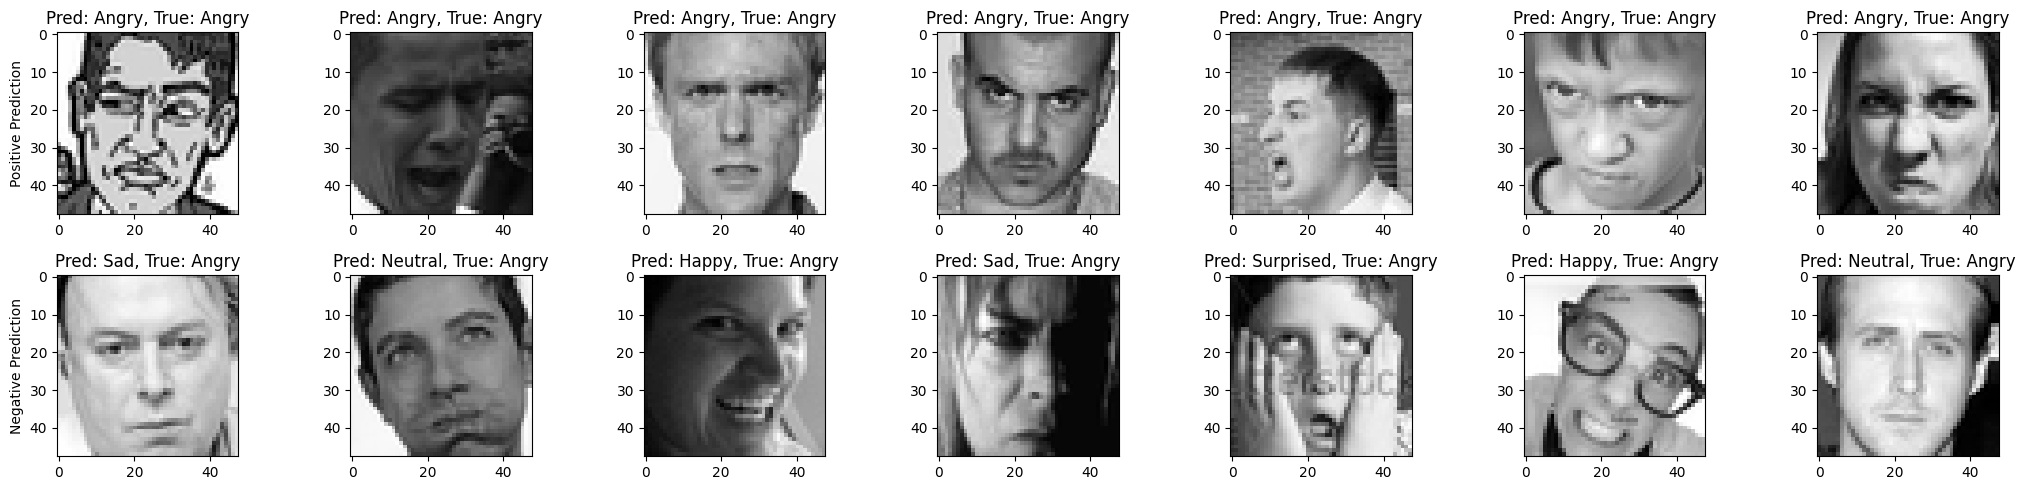

In [95]:
compare_pred('Angry', prediction)

* Pada prediksi angry, diketahui bahwa model dapat dengan mudah memprediksi kelas angry apabila pada gambar terlihat alis yang mengkerut dan mata yang menajam
* Pada beberapa kasus, model tidak dapat memprediksi kelas angry apabila tidak memiliki fitur tersebut, sebagai contoh:
    * apabila mata tidak menajam dan alis tidak mengkerut, maka gambar akan diprediksi sebagai neutral
    * apabila mulut terbuka akan terdeteksi sebagai happy
    * apabila terdapat tangan pada wajah akan terdeteksi sebagai surprised

### Disgusted Prediction

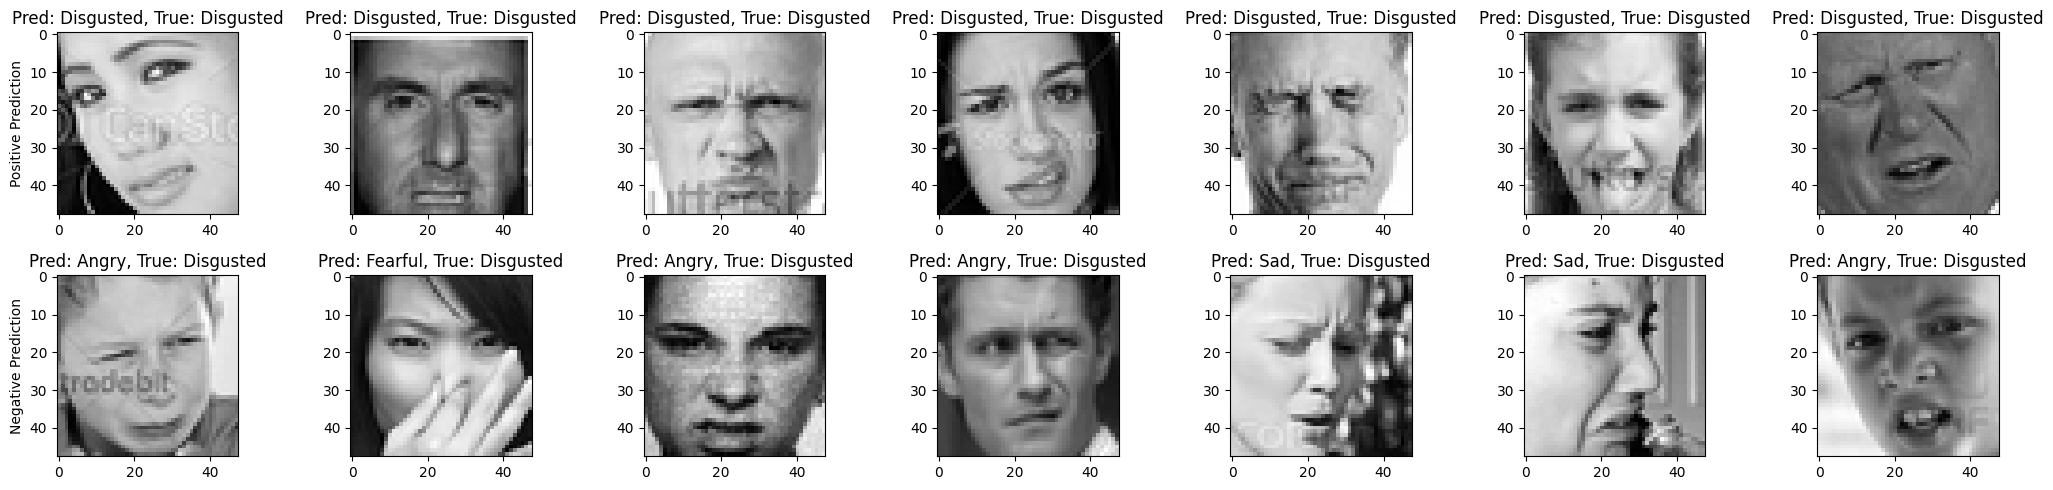

In [96]:
compare_pred('Disgusted', prediction)

* Pada kelas disgusted, salah satu fitur wajah yang menonjol pada prediksi adalah bibir yang menegang dan sedikit terangkat, serta alis dan mata yang menajam
* Data yang diprediksi salah sebagai berikut:
    * apabila hanya terdapat alis dan mata yang menajam, akan terprediksi sebagai angry
    * apabila bibir menurun akan terprediksi sebagai sad
    * apabila terdapat tangan yang menutup wajah akan terprediksi sebagai fearful

### Fearful Prediction

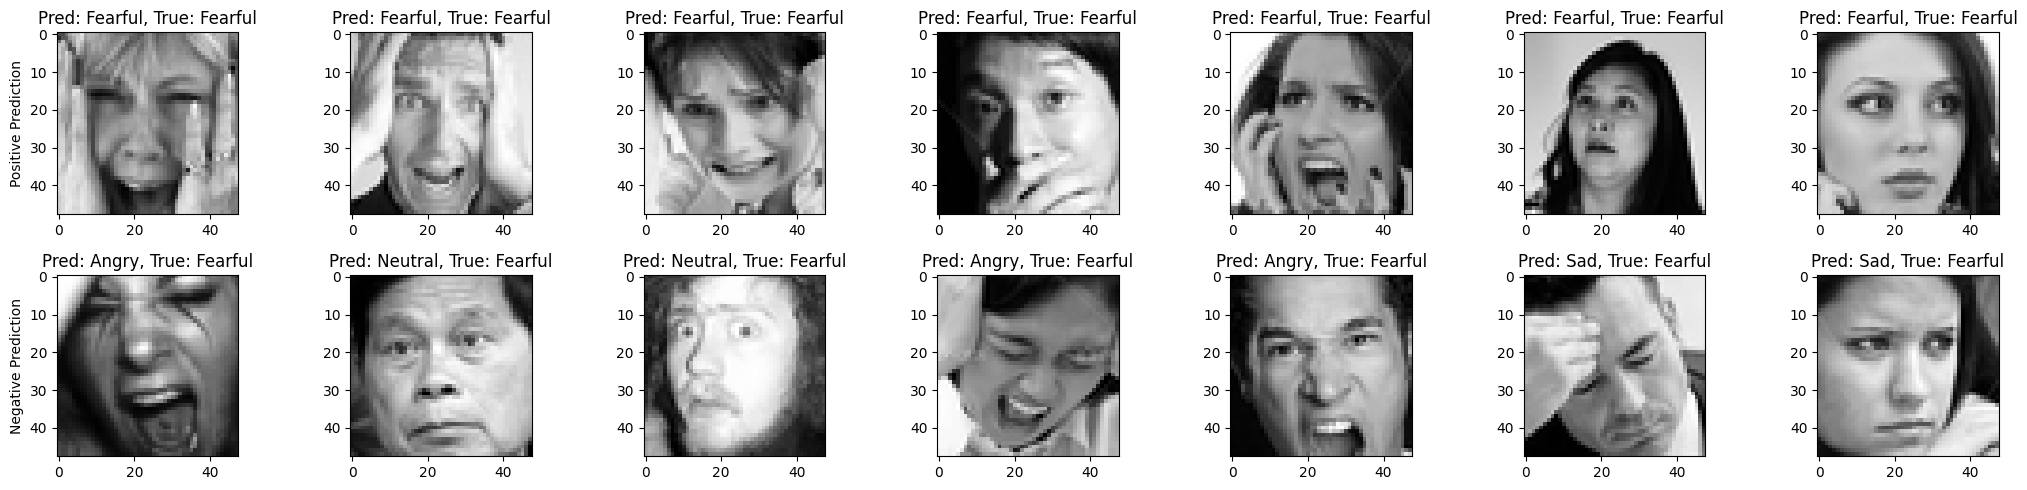

In [97]:
compare_pred('Fearful', prediction)

* Pada kelas fearful, fitur yang paling menonjol adalah terdapat tangan yang menutupi wajah, dan alis terlihat mengkerut
* pada banyak kasus apabila tidak terdapat tangan yang menutupi wajah, gambar akan diprediksi sebagai bukan fearful

### Happy Prediction

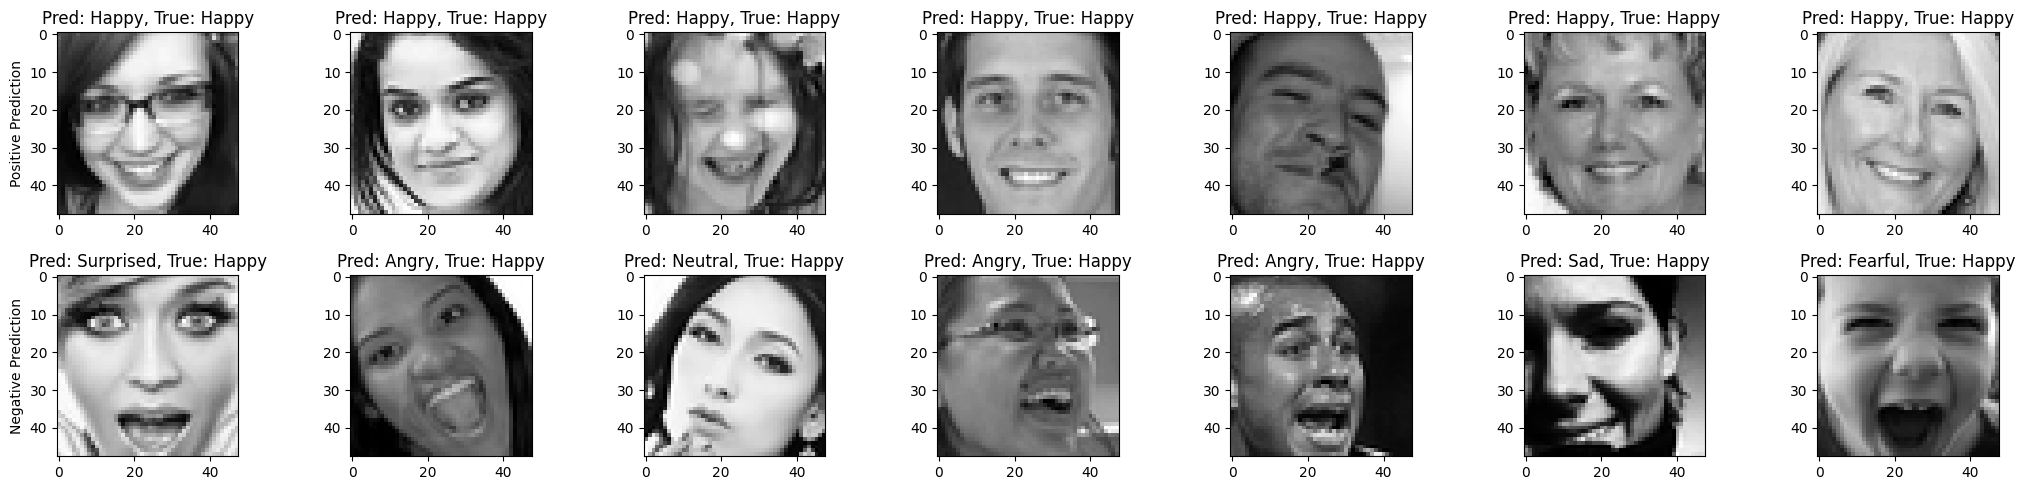

In [98]:
compare_pred('Happy', prediction)

* Pada kelas happy, gambar yang diprediksi benar memiliki fitur mulut tersenyum dan mata yang menajam
* Apabila mata tidak menyipit walaupun tersenyum lebar, akan diprediksi sebagai surprised atau angry

### Neutral Prediction

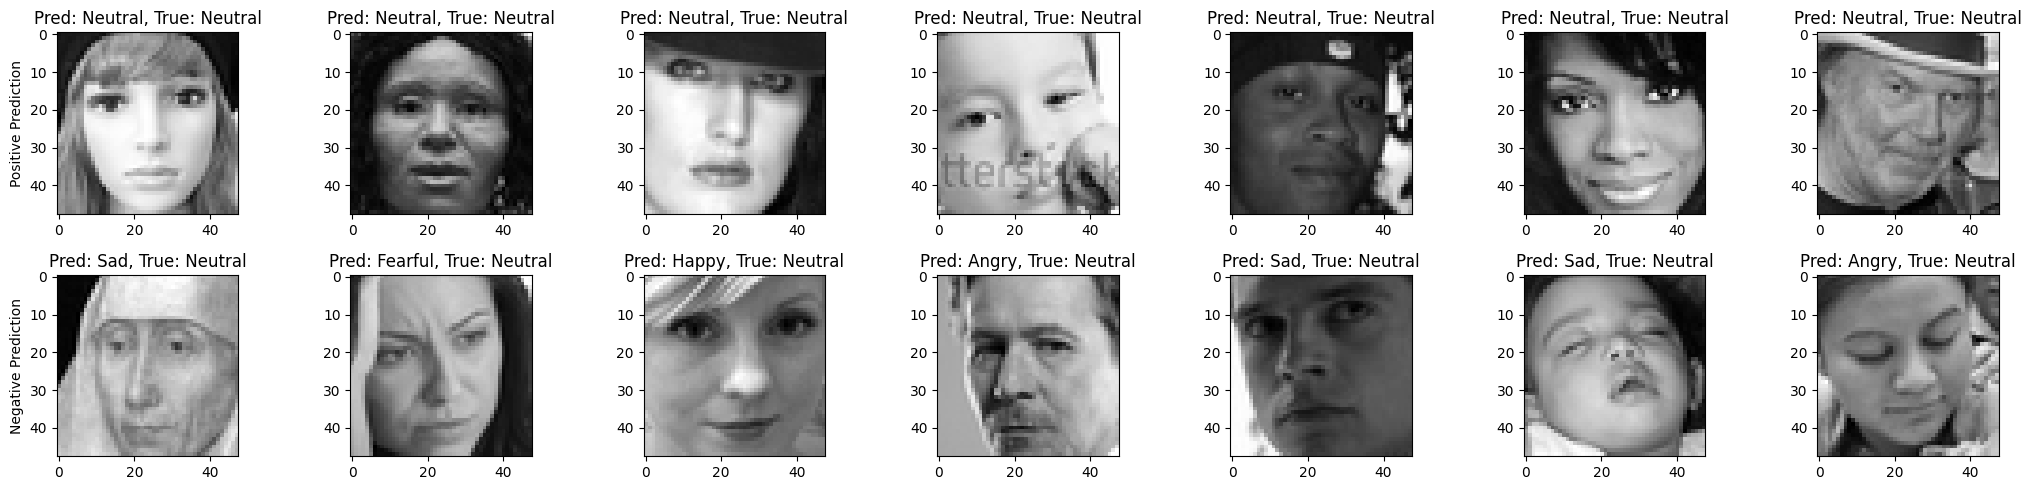

In [99]:
compare_pred('Neutral', prediction)

* Pada kelas neutral, gambar yang diprediksi benar memiliki fitur wajah yang datar dan tidak ada yang menonjol
* Apabila terdapat sedikit perbedaan pada wajah maka tidak akan terprediksi netural, contoh: 
  * Apabila mata sedikit lesu maka akan terprediksi sebagai sad
  * Apabila mata dan alis sedikit menajam maka akan terprediksi sebagai angri

### Sad Prediction

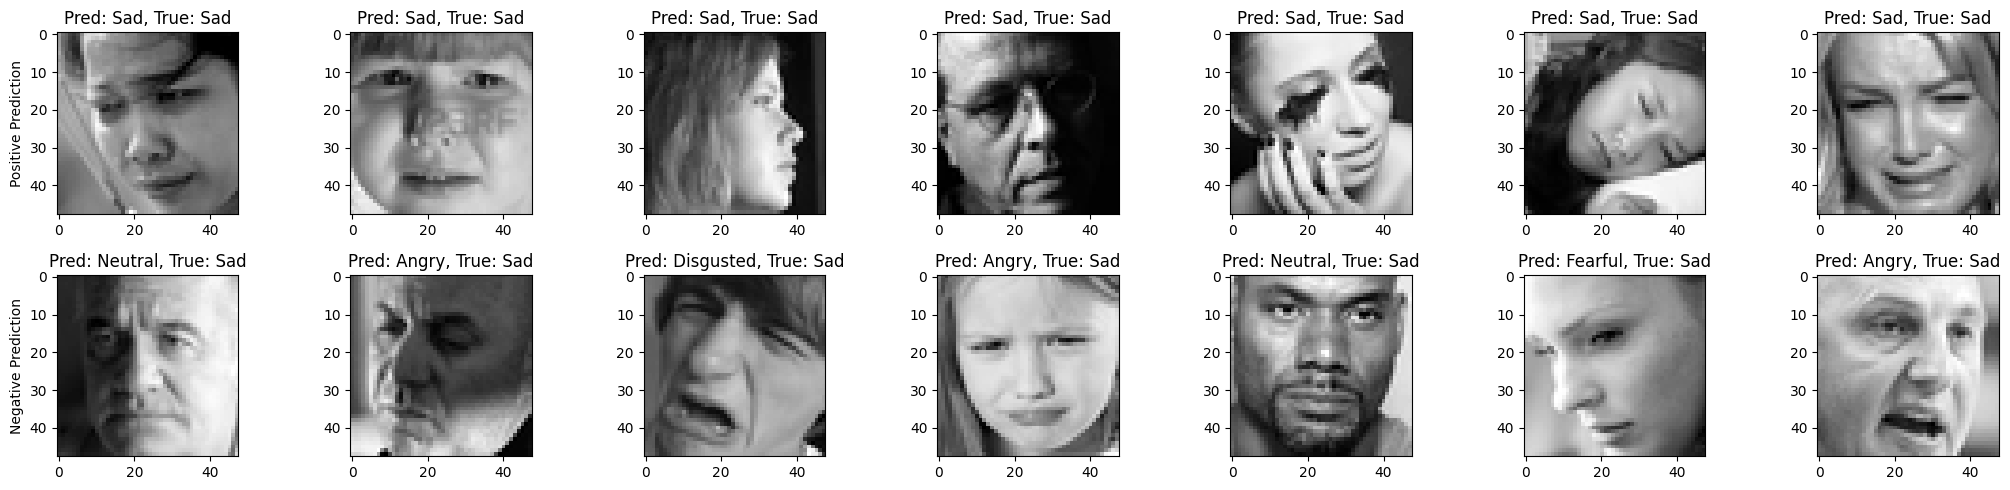

In [100]:
compare_pred('Sad', prediction)

* Pada prediksi sad, terlihat terdapat mata yang menangis atau berkaca-kaca, bibir yang menurun dan mulut biasanya terbuka tetapi tidak lebar
* Pada beberapa kasus, apabila bibir menurun tetapi tidak terlihat mata yang menangis, akan terprediksi sebagai angry atau sad

### Suprised Prediction

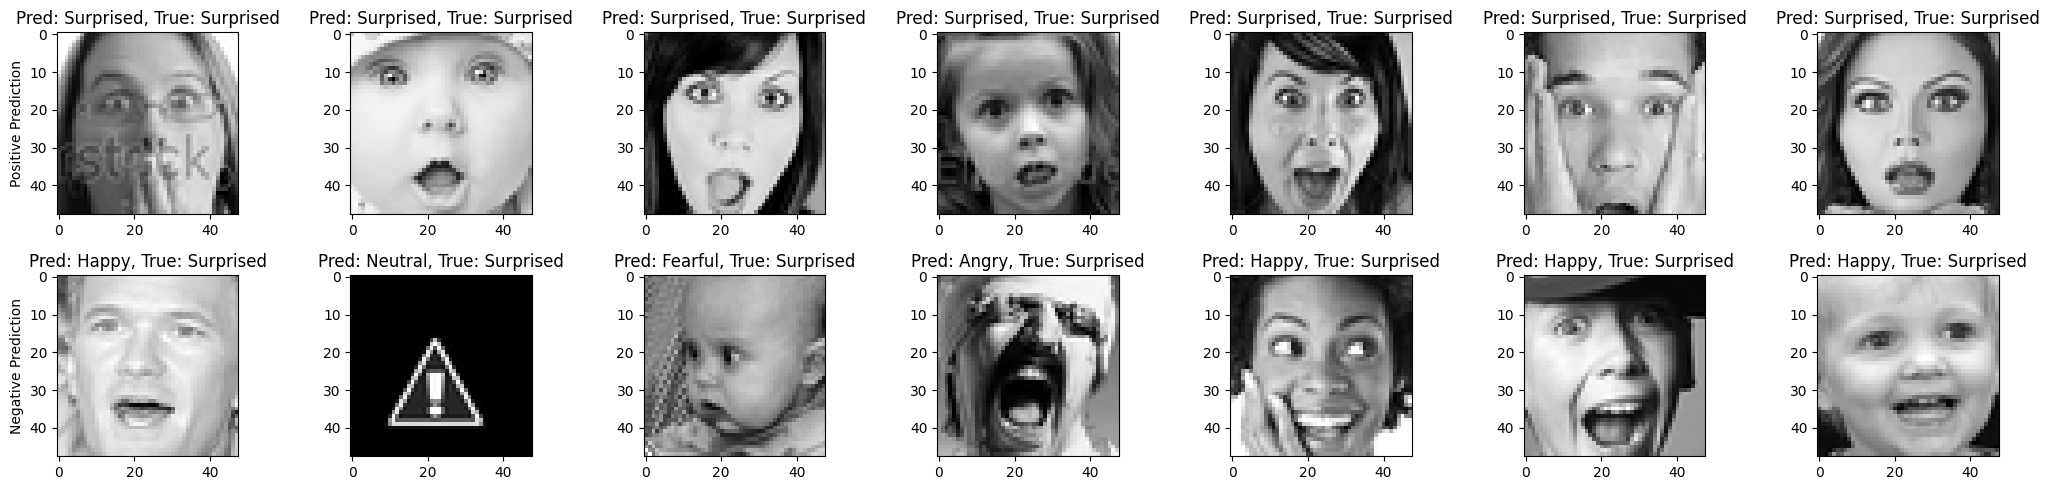

In [101]:
compare_pred('Surprised', prediction)

* Pada prediksi surprised, fitur yang paling menonjol adalah mata yang melebar, serta mulut yang terbuka lebar
* Apabila tidak terdapat fitur itu, maka tidak akan diprediksi sebagai surprised, contoh:
  * Apabila mata tidak melebar, akan terprediksi sebagai happy
  * Apabila mata tidak terdapat mulut yang terbuka akan terprediksi sebagai fearful
  * Apabila mulut terbuka sangat lebar akan terprediksi sebagai Angry

## Kesimpulan

### Pemodelan

**Dari Hasil pemodelan didapatkan kesimpulan sebagai berikut**

Secara overall, model masih tergolong **underfit, tetapi dapat memprediksi beberapa kelas dengan baik**. hal ini bisa disebabkan oleh beberapa hal:
* Jumlah data yang tidak seimbang, pada data training, lebih banyak data pada kelas Happy, dan hanya sedikit data pada kelas Disgusted
* Terdapat beberapa gambar yang memiliki angel yang sulit teridentifikasi, hal ini dapat memengaruhi model dalam deteksi fitur dari kelas gambar tersebut
* Missing values pada dataset tidak dapat dihandle sepenuhnya, dibutuhkan waktu lebih banyak untuk melakukan pengecekan missing values pada datasest

Model terbaik yang didapatkan pada project ini adalah:
* Sequential API
* Menggunakan 6 Convolution Layer dan 2 Dense Layer
* Dengan total 6 Juta Neuron 

Dengan hasil klasifikasi

              precision    recall  f1-score   support

           0       0.58      0.63      0.61       958
           1       0.68      0.55      0.61       111
           2       0.58      0.43      0.50      1024
           3       0.88      0.88      0.88      1774
           4       0.59      0.72      0.65      1233
           5       0.58      0.53      0.55      1247
           6       0.76      0.83      0.79       831

    accuracy                           0.68      7178

**Penjelasan Classification Report**
|   | Precision  | Recall  |
|---|---|---|
| **Angry** | Precision **58%** yang berarti sebanyak 58% dari data angry yang diprediksi adalah benar | Recall **63%** yang berarti model dapat mengidentifikasi 63% data angry secara benar    |
| **Disgusted** | Precision **68%** yang berarti sebanyak 68% dari data disgusted yang diprediksi adalah benar | Recall **55%** yang berarti model dapat mengidentifikasi 55% data disgusted secara benar |
| **Fearful** | Precision **58%** yang berarti sebanyak 58% dari data fearful yang diprediksi adalah benar | Recall **43%** yang berarti model dapat mengidentifikasi 43% data fearful secara benar |
| **Happy** | Precision **88%** yang berarti sebanyak 88% dari data happy yang diprediksi adalah benar | Recall **88%** yang berarti model dapat mengidentifikasi 88% data happy secara benar |
| **Neutral** | Precision **59%** yang berarti sebanyak 59% dari data disgusted yang diprediksi adalah benar | Recall **72%** yang berarti model dapat mengidentifikasi 72% data neutral secara benar |
| **Sad** | Precision **58%** yang berarti sebanyak 58% dari data disgusted yang diprediksi adalah benar | Recall **53%** yang berarti model dapat mengidentifikasi 53% data sad secara benar |
| **Surprised** | Precision **76%** yang berarti sebanyak 76% dari data disgusted yang diprediksi adalah benar | Recall **83%** yang berarti model dapat mengidentifikasi 83% data surprised secara benar |

Dari nilai recal dan precision tersebut dapat diambil kesimpulan sebagai berikut:
* Model dapat memprediksi Happy dan Surprised cukup baik dengan nilai yang cukup tinggi
* Untuk kelas Neutral dan Angry, model memprediksi data baru dengan benar, tetapi juga banyak memiliki data prediksi yang salah
* Untuk kelas Disgusted, Fearful dan Sad, model dapat dengan akurat memprediksi data yang benar, tetapi banyak data yang seharusnya benar dan tidak terprediksi sebagai benar

Berdasarkan hasil classification report, didapatkan kesimpulan bahwa model masih sedikit underfitting, dan dapat dilakukan beberapa improvement lebih lanjut diantaranya:
* Menggunakan transfer learning agar performa model lebih baik
* Bisa menambahkan epoch serta mengatur parameter yang digunakan agar model dapat mempelajari data lebih banyak tetapi tetap menghindari overfitting ataupun gradient vanishin
* Disarankan menggunakan Functional API agar model lebih flexible dalam melakukan training terhadap data

Prediksi pada data ekspresi manusia tidak dapat 100% akurat, hal ini disebabkan karena ekspresi sebenarnya adalah sebuah spektrum sehingga dapat terjadi beberapa ekspresi secara bersamaan, oleh karena itu pada prediksi yang akan kita lihat adalah keseluruhan data prediksi, bukan hanya kelas dengan nilai tertinggi. Contoh dapat dilihat pada file inference

*Pembahasan lebih lanjut terkait inferencing model terdapat pada file `h8dsft_P2M2_ediashta_inference`*

### Business

* Model ini dapat digunakan sebagai langkah awal percobaan sistem survey baru yang akan diterapkan oleh WalMart .Inc 
* Sebaiknya dilakukan pengembangan model lebih lanjut sebelum digunakan untuk memastikan bahwa model memiliki performa yang terbaik
* Dalam melakukan survey terkait kepuasan pelanggan, tidak cukup dilakukan klasifikasi pada ekspresi wajah pelanggan saja, sebaiknya digabungkan dengan menggunakan metrics lain yang bersifat lebih subjektif terhadap tiap pelanggannya. Hal ini bertujuan agar hasil survey lebih akurat dan memiliki scope yang lebih luas

* Perlu diperhatikan data ethics dari penggunaan model ini terhadap pelanggan, WalMart. Inc harus memastikan keamanan dari data wajah pelanggan dan tidak menggunakannya untuk kepentingan yang merugikan
* Pastikan bahwa pelanggan memiliki consent bahwa mereka akan mengikuti survey ini dan dilakukan pendeteksian pada ekspresi mereka saat berbelanja